In [1]:
import os
import h5py
import shutil
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy import table
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)

%load_ext autoreload
from functions import create_cutouts


# Initialize hdf5 file

In [2]:
os.path.expandvars("$SLURM_TMPDIR")

'/localscratch/anahoban.2889427.0'

In [3]:
scratch = os.path.expandvars("$SCRATCH")

In [4]:
#initialie file in scratch
hf = h5py.File(scratch + "/" + "cutouts_filtered_128_urz.h5", "r+")
hf.close()

In [26]:
#intitialize file in tmpdir, to work there
src = os.path.expandvars("$SCRATCH") + "/cutouts_filtered_128_urz.h5"
dest = os.path.expandvars("$SLURM_TMPDIR") + "/"
shutil.copy2(src, dest)

'/localscratch/anahoban.2889427.0/cutouts_filtered_128_urz.h5'

In [27]:
hf = h5py.File(dest + "cutouts_filtered_128_urz.h5", "r+")
image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"

In [7]:
tile_list = open(image_dir + "tiles.list", "r")

In [8]:
#test
for tile in tile_list:
    tile = tile[:-1] # Remove new line character
    channels = tile.split(" ")
    print(channels)
    break

['CFIS.134.283.r']


In [9]:
# Only use tiles with all five channels

tile_list = open(image_dir + "tiles.list", "r")

u_images = []
u_weights = []
g_images = []
g_weights = []
r_images = []
r_weights = []
i_images= []
i_weights = []
z_images = []
z_weights = []
u_cat = []
r_cat = []

for tile in tile_list:
    tile = tile[:-1] # Remove new line character
    channels = tile.split(" ") #tile.channel tile.channel ... (we just want tiles with all 5 channels)
    if len(channels) == 5: # Order is u,g,r,i,z
        u_images.append(image_dir + channels[0] + ".fits")
        u_weights.append(image_dir + channels[0] + ".weight.fits.fz")
        g_images.append(image_dir + channels[1] + ".fits")
        g_weights.append(image_dir + channels[1] + ".wt.fits")
        r_images.append(image_dir + channels[2] + ".fits")
        r_weights.append(image_dir + channels[2] + ".weight.fits.fz")
        i_images.append(image_dir + channels[3] + ".fits")
        i_weights.append(image_dir + channels[3] + ".wt.fits")
        z_images.append(image_dir + channels[4] + ".fits")
        z_weights.append(image_dir + channels[4] + ".wt.fits")
        u_cat.append(image_dir + channels[0] + ".cat")
        r_cat.append(image_dir + channels[2] + ".cat")
        #cats.append(image_dir + channels[4] + ".cat")
tile_list.close()

In [15]:
print(len(u_images))
print(len(u_weights))
print(len(g_images))
print(len(g_weights))
print(len(r_images))
print(len(r_weights))
print(len(i_images))
print(len(i_weights))
print(len(z_images))
print(len(z_weights))
print(len(u_cat), len(r_cat))

41
41
41
41
41
41
41
41
41
41
41 41


### there are 41 tiles with all 5 channels, but we're using only 20 of them

In [13]:
 os.path.basename(u_images[0])

'CFIS.180.272.u.fits'

In [10]:
# Copy tiles to $SLURM_TMPDIR
start = 0
end = 20 #20
for n in range(start, end):
    shutil.copy2(u_images[n], dest)
    shutil.copy2(u_weights[n], dest)
    shutil.copy2(g_images[n], dest)
    shutil.copy2(g_weights[n], dest)
    shutil.copy2(r_images[n], dest)
    shutil.copy2(r_weights[n], dest)
    shutil.copy2(i_images[n], dest)
    shutil.copy2(i_weights[n], dest)
    shutil.copy2(z_images[n], dest)
    shutil.copy2(z_weights[n], dest)
    shutil.copy2(u_cat[n], dest)
    #shutil.copy2(r_cat[n], dest)
    
    u_images[n] = os.path.abspath(dest + os.path.basename(u_images[n]))
    u_weights[n] = os.path.abspath(dest + os.path.basename(u_weights[n]))
    g_images[n] = os.path.abspath(dest + os.path.basename(g_images[n]))
    g_weights[n] = os.path.abspath(dest + os.path.basename(g_weights[n]))
    r_images[n] = os.path.abspath(dest + os.path.basename(r_images[n]))
    r_weights[n] = os.path.abspath(dest + os.path.basename(r_weights[n]))
    i_images[n] = os.path.abspath(dest + os.path.basename(i_images[n]))
    i_weights[n] = os.path.abspath(dest + os.path.basename(i_weights[n]))
    z_images[n] = os.path.abspath(dest + os.path.basename(z_images[n]))
    z_weights[n] = os.path.abspath(dest + os.path.basename(z_weights[n]))    
    u_cat[n] = os.path.abspath(dest + os.path.basename(u_cat[n]))
    #r_cat[n] = os.path.abspath(dest + os.path.basename(r_cat[n]))

# Store cutouts into hdf5 file

## list_xy function to add objects to catalogue without duplicates

In [18]:
#not final
def list_xy(cat_1, cat_2):
    x_list = []
    y_list = []
    
    #to keep original list 'short' 
    x_new_list = []
    y_new_list = []
    
    #make initial cutout list
    for i in range(len(cat_1)): #each cutout in tile
        x_list.append( cat_1["X_IMAGE"][i] )
        y_list.append( cat_1["Y_IMAGE"][i] )
    
    for i in range(len(cat_2)): #look at cutouts from other ban

        new_x = cat_2["X_IMAGE"][i]
        new_y = cat_2["Y_IMAGE"][i]
        
        #record x_new,y_new for which x position is within 3 pixels of already exising x,y
        #x_dupli = [x_list.index(x) for x in x_list if np.abs(x - new_x) <= 3] 
        #y_dupli = [y_list.index(y) for y in y_list if np.abs(y - new_y) <= 3]
        
        dist2 = (x_list - new_x)**2 + (y_list - new_y)**2
        
        duplicate = True in (ele <= 9 for ele in dist2)
        
        if duplicate == False:
            x_new_list.append(new_x)
            y_new_list.append(new_y) 
        #if the lists do not agree, there is no duplicate, we add the new object
        #if len(set(x_dupli).intersection(y_dupli)) == 0 or x_dupli == None :
            #x_list.append(new_x)
            #y_list.append(new_y)
        #else: #there is a duplicate
            #dup += 1
            
    x_list = x_list + x_new_list
    y_list = y_list + y_new_list
    return x_list, y_list   

### testing list_xy function

In [19]:
x_list = [1, 2,  3, 4]
y_list = [4 ,5, 66, 7]


In [28]:
new_x, new_y = 5, 4
x_new_list = []
y_new_list = []
dist2 = (np.asarray(x_list) - new_x)**2 + (np.asarray(y_list) - new_y)**2

duplicate = True in (ele <= 9 for ele in dist2)
print(duplicate)
if duplicate == False:
    x_new_list.append(new_x)
    y_new_list.append(new_y) 

x_list = x_list + x_new_list
y_list = y_list + y_new_list
print(x_list, y_list)   


CPU times: user 1e+03 ns, sys: 5 µs, total: 6 µs
Wall time: 11 µs
True
[1, 2, 3, 4, 1, 5] [4, 5, 66, 7, 14, 4]


In [ ]:
## Testing function on our data 

In [34]:
n=0
main_cat = table.Table.read(u_cat[n], format="ascii.sextractor")
app_cat  = table.Table.read(r_cat[n], format="ascii.sextractor")

In [35]:
%time
x,y = list_xy(main_cat,app_cat)

CPU times: user 1 µs, sys: 6 µs, total: 7 µs
Wall time: 11.7 µs


In [117]:
 main_cat["FLAGS"]

8
0
0
24
0
0
0
0
16
0
24


## Storing cutouts

In [28]:
%autoreload
cutout_size = 128
img_cutout = np.zeros((cutout_size, cutout_size, 5))
wt_cutout = np.zeros((cutout_size, cutout_size, 5))
for n in range(start, end):
    root = os.path.basename(u_images[n])[5:12] + "/" # XXX.XXX id
    
    u_image = fits.open(u_images[n], memmap=True)
    u_weight = fits.open(u_weights[n], memmap=True)
    g_image = fits.open(g_images[n], memmap=True)
    g_weight = fits.open(g_weights[n], memmap=True)
    r_image = fits.open(r_images[n], memmap=True)
    r_weight = fits.open(r_weights[n], memmap=True)
    i_image = fits.open(i_images[n], memmap=True)
    i_weight = fits.open(i_weights[n], memmap=True)
    z_image = fits.open(z_images[n], memmap=True)
    z_weight = fits.open(z_weights[n], memmap=True)
    main_cat = table.Table.read(u_cat[n], format="ascii.sextractor")
    #app_cat = table.Table.read(r_cat[n], format="ascii.sextractor")
    
    img_group = hf.create_group(root + "IMAGES")
    wt_group = hf.create_group(root + "WEIGHTS")

    count = 0
    #cutouts from r band
    for i in range(len(main_cat)): #each cutout in tile
        if main_cat["FLAGS"][i] != 0 or main_cat["MAG_AUTO"][i] >= 99.0 or main_cat["MAGERR_AUTO"][i] <= 0 or main_cat["MAGERR_AUTO"][i] >= 1:
            continue
        
        x = main_cat["X_IMAGE"][i]
        y = main_cat["Y_IMAGE"][i]
        
        (r_img, r_wt) = create_cutouts(r_image[0], r_weight[1], x, y, "r")
        if r_img is None:
            continue
        (u_img, u_wt) = create_cutouts(u_image[0], u_weight[1], x, y, "u")
        if u_img is None:
            continue
        (g_img, g_wt) = create_cutouts(g_image[0], g_weight[0], x, y, "g")
        if g_img is None:
            continue
        (i_img, i_wt) = create_cutouts(i_image[0], i_weight[0], x, y, "i")
        if i_img is None:
            continue
        (z_img, z_wt) = create_cutouts(z_image[0], z_weight[0], x, y, "z")
        if z_img is None:
            continue
        
        img_cutout[:,:,0] = u_img
        img_cutout[:,:,1] = g_img
        img_cutout[:,:,2] = r_img
        img_cutout[:,:,3] = i_img
        img_cutout[:,:,4] = z_img
        wt_cutout[:,:,0] = u_wt
        wt_cutout[:,:,1] = g_wt
        wt_cutout[:,:,2] = r_wt
        wt_cutout[:,:,3] = i_wt
        wt_cutout[:,:,4] = z_wt

        img_group.create_dataset(f"c{count}", data=img_cutout)
        wt_group.create_dataset(f"c{count}", data=wt_cutout)
        count += 1
    
    u_image.close()
    u_weight.close()
    g_image.close()
    g_weight.close()
    r_image.close()
    r_weight.close()
    i_image.close()
    i_weight.close()
    z_image.close()
    z_weight.close()
    print(f"Tile {n+1} completed")

Tile 1 completed


# Test getting and plotting cutouts from hdf5 file

In [29]:
hf.get('180.272/IMAGES').keys()

<KeysViewHDF5 ['c0', 'c1', 'c10', 'c100', 'c101', 'c102', 'c103', 'c104', 'c105', 'c106', 'c107', 'c108', 'c109', 'c11', 'c110', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c12', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'c129', 'c13', 'c130', 'c131', 'c132', 'c133', 'c134', 'c135', 'c136', 'c137', 'c138', 'c139', 'c14', 'c140', 'c141', 'c142', 'c143', 'c144', 'c145', 'c146', 'c147', 'c148', 'c149', 'c15', 'c150', 'c151', 'c152', 'c153', 'c154', 'c155', 'c156', 'c157', 'c158', 'c159', 'c16', 'c160', 'c161', 'c162', 'c163', 'c164', 'c165', 'c166', 'c167', 'c168', 'c169', 'c17', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c18', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c19', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c2', 'c20', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c21', 'c2

In [30]:
group = hf.get("180.272/IMAGES")
plot_cutouts = np.array(group.get("c110"))
print(plot_cutouts.shape)

(128, 128, 5)


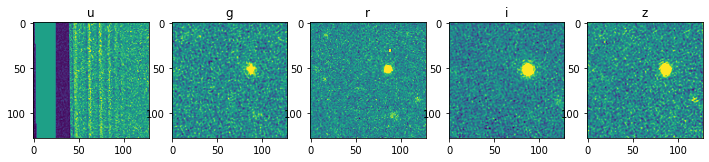

In [31]:
channels = ["u", "g", "r", "i", "z"]
fig, axes = plt.subplots(1,5, figsize=(12,8))
for i in range(5):
    norm = ImageNormalize(plot_cutouts[:,:,i], interval=ZScaleInterval())
    axes[i].imshow(plot_cutouts[:,:,i], norm=norm)
    axes[i].set_title(channels[i])

In [32]:
group_weight = hf.get("180.272/WEIGHTS")
plot_weights = np.array(group_weight.get("c110"))
print(plot_weights.shape)

(128, 128, 5)


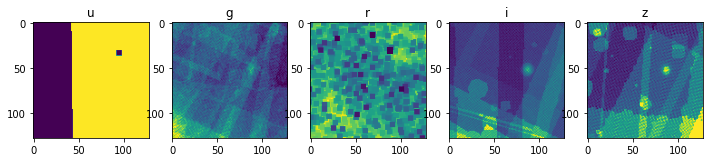

In [33]:
channels = ["u", "g", "r", "i", "z"]
fig, axes = plt.subplots(1,5, figsize=(12,8))
for i in range(5):
    norm = ImageNormalize(plot_weights[:,:,i], interval=ZScaleInterval())
    axes[i].imshow(plot_weights[:,:,i], norm=norm)
    axes[i].set_title(channels[i])

In [34]:
hf.close()

In [50]:
hf.close()
src = os.path.expandvars("$SLURM_TMPDIR") + "/cutouts_filtered_128_urz.h5"
dest = os.path.expandvars("$SCRATCH") + "/"
shutil.copy2(src, dest)

'/scratch/anahoban/cutouts_filtered_128_urz.h5'